In [256]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import glob

https://mne.tools/dev/auto_tutorials/time-freq/50_ssvep.html#sphx-glr-auto-tutorials-time-freq-50-ssvep-py

In [257]:
BASE_PATH = "/mnt/nfs/homes/oel-ayad/sgoinfre"
file = f"{BASE_PATH}/tpv/files/S001/S001R09.edf"
raw = mne.io.read_raw_edf(file, preload=True)
print(raw.ch_names[-3:])
channel_renaming_dict = {name: name.replace(".", "").upper().replace("Z", "z").replace("FP", "Fp") for name in raw.ch_names}
# channel_renaming_dict = {name: name.upper() for name in raw.ch_names}
raw.rename_channels(channel_renaming_dict)
raw.drop_channels(['T9','T10'])
print(raw.ch_names[-3:])

Extracting EDF parameters from /mnt/nfs/homes/oel-ayad/sgoinfre/tpv/files/S001/S001R09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
['Oz..', 'O2..', 'Iz..']
['Oz', 'O2', 'Iz']


In [258]:
current_mont = mne.channels.make_standard_montage("biosemi64")
current_mont.get_positions()
raw = raw.set_montage(current_mont, on_missing='ignore')

In [259]:
# Set montage
# montage = mne.channels.make_standard_montage(kind="Ft7.")
# raw.set_montage(montage, verbose=False)

# Set common average reference
raw.set_eeg_reference("average", projection=False, verbose=False)

# Apply bandpass filter
raw.filter(l_freq=0.1, h_freq=None, fir_design="firwin", verbose=False)

# Construct epochs
# event_id = {"12hz": 255, "15hz": 155}
events, event_id = mne.events_from_annotations(raw, verbose=False)
tmin, tmax = -1.0, 20.0  # in s
baseline = None
epochs = mne.Epochs(
    raw,
    events=events,
    event_id=[event_id["T0"], event_id["T1"]],
    tmin=tmin,
    tmax=tmax,
    baseline=baseline,
    verbose=False,
)

In [260]:
tmin = 1.0
tmax = 100.0
fmin = 1.0
fmax = 80.0
sfreq = epochs.info["sfreq"]

spectrum = epochs.compute_psd(
    "welch",
    n_overlap=0,
    n_per_seg=None,
    tmin=tmin,
    tmax=tmax,
    fmin=fmin,
    fmax=fmax,
    window="boxcar",
    verbose=False,
)
psds, freqs = spectrum.get_data(return_freqs=True)

In [261]:
def snr_spectrum(psd, noise_n_neighbor_freqs=1, noise_skip_neighbor_freqs=1):
    """Compute SNR spectrum from PSD spectrum using convolution.

    Parameters
    ----------
    psd : ndarray, shape ([n_trials, n_channels,] n_frequency_bins)
        Data object containing PSD values. Works with arrays as produced by
        MNE's PSD functions or channel/trial subsets.
    noise_n_neighbor_freqs : int
        Number of neighboring frequencies used to compute noise level.
        increment by one to add one frequency bin ON BOTH SIDES
    noise_skip_neighbor_freqs : int
        set this >=1 if you want to exclude the immediately neighboring
        frequency bins in noise level calculation

    Returns
    -------
    snr : ndarray, shape ([n_trials, n_channels,] n_frequency_bins)
        Array containing SNR for all epochs, channels, frequency bins.
        NaN for frequencies on the edges, that do not have enough neighbors on
        one side to calculate SNR.
    """
    # Construct a kernel that calculates the mean of the neighboring
    # frequencies
    averaging_kernel = np.concatenate(
        (
            np.ones(noise_n_neighbor_freqs),
            np.zeros(2 * noise_skip_neighbor_freqs + 1),
            np.ones(noise_n_neighbor_freqs),
        )
    )
    averaging_kernel /= averaging_kernel.sum()

    # Calculate the mean of the neighboring frequencies by convolving with the
    # averaging kernel.
    mean_noise = np.apply_along_axis(
        lambda psd_: np.convolve(psd_, averaging_kernel, mode="valid"), axis=-1, arr=psd
    )

    # The mean is not defined on the edges so we will pad it with nas. The
    # padding needs to be done for the last dimension only so we set it to
    # (0, 0) for the other ones.
    edge_width = noise_n_neighbor_freqs + noise_skip_neighbor_freqs
    pad_width = [(0, 0)] * (mean_noise.ndim - 1) + [(edge_width, edge_width)]
    mean_noise = np.pad(mean_noise, pad_width=pad_width, constant_values=np.nan)

    return psd / mean_noise

In [262]:
snrs = snr_spectrum(psds, noise_n_neighbor_freqs=3, noise_skip_neighbor_freqs=1)

/tmp/ipykernel_1708766/1831162948.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


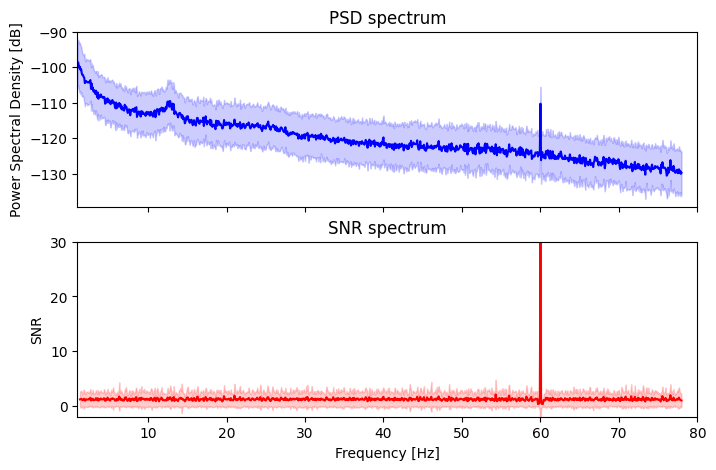

In [263]:
fig, axes = plt.subplots(2, 1, sharex="all", sharey="none", figsize=(8, 5))
freq_range = range(
    np.where(np.floor(freqs) == 1.0)[0][0], np.where(np.ceil(freqs) == fmax - 1)[0][0]
)

psds_plot = 10 * np.log10(psds)
psds_mean = psds_plot.mean(axis=(0, 1))[freq_range]
psds_std = psds_plot.std(axis=(0, 1))[freq_range]
axes[0].plot(freqs[freq_range], psds_mean, color="b")
axes[0].fill_between(
    freqs[freq_range], psds_mean - psds_std, psds_mean + psds_std, color="b", alpha=0.2
)
axes[0].set(title="PSD spectrum", ylabel="Power Spectral Density [dB]")

# SNR spectrum
snr_mean = snrs.mean(axis=(0, 1))[freq_range]
snr_std = snrs.std(axis=(0, 1))[freq_range]

axes[1].plot(freqs[freq_range], snr_mean, color="r")
axes[1].fill_between(
    freqs[freq_range], snr_mean - snr_std, snr_mean + snr_std, color="r", alpha=0.2
)
axes[1].set(
    title="SNR spectrum",
    xlabel="Frequency [Hz]",
    ylabel="SNR",
    ylim=[-2, 30],
    xlim=[fmin, fmax],
)
fig.show()

In [264]:
# define stimulation frequency
stim_freq = 12.0

In [265]:
# find index of frequency bin closest to stimulation frequency
i_bin_12hz = np.argmin(abs(freqs - stim_freq))
# could be updated to support multiple frequencies

# for later, we will already find the 15 Hz bin and the 1st and 2nd harmonic
# for both.
i_bin_24hz = np.argmin(abs(freqs - 24))
i_bin_36hz = np.argmin(abs(freqs - 36))
i_bin_15hz = np.argmin(abs(freqs - 15))
i_bin_30hz = np.argmin(abs(freqs - 30))
i_bin_45hz = np.argmin(abs(freqs - 45))

In [266]:
i_trial_12hz = np.where(epochs.events[:, 2] == event_id["T0"])[0]
i_trial_15hz = np.where(epochs.events[:, 2] == event_id["T1"])[0]

In [267]:
# Define different ROIs
roi_vis = [
'Fc3.',
 'Fc1.',
 'Fcz.',
 'Fc2.',
 'Fc4.',
 'Fc6.',
 'C5..',
 'C3..',
 'C1..',
 'Cz..',
 'C2..',
 'C4..',
 'C6..',
]  # visual roi

# Find corresponding indices using mne.pick_types()
picks_roi_vis = mne.pick_types(
    epochs.info, eeg=True, stim=False, exclude="bads", selection=roi_vis
)

In [268]:
snrs_target = snrs[i_trial_12hz, :, i_bin_12hz][:, picks_roi_vis]
print("sub 2, 12 Hz trials, SNR at 12 Hz")
print(f"average SNR (occipital ROI): {snrs_target.mean()}")

sub 2, 12 Hz trials, SNR at 12 Hz
average SNR (occipital ROI): nan


/tmp/ipykernel_1708766/1300030829.py:3: RuntimeWarning: Mean of empty slice.
  print(f"average SNR (occipital ROI): {snrs_target.mean()}")
/mnt/nfs/homes/oel-ayad/.local/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [269]:
from scipy.stats import ttest_rel

In [270]:
mne.channels.get_builtin_montages()

['standard_1005',
 'standard_1020',
 'standard_alphabetic',
 'standard_postfixed',
 'standard_prefixed',
 'standard_primed',
 'biosemi16',
 'biosemi32',
 'biosemi64',
 'biosemi128',
 'biosemi160',
 'biosemi256',
 'easycap-M1',
 'easycap-M10',
 'EGI_256',
 'GSN-HydroCel-32',
 'GSN-HydroCel-64_1.0',
 'GSN-HydroCel-65_1.0',
 'GSN-HydroCel-128',
 'GSN-HydroCel-129',
 'GSN-HydroCel-256',
 'GSN-HydroCel-257',
 'mgh60',
 'mgh70',
 'artinis-octamon',
 'artinis-brite23',
 'brainproducts-RNP-BA-128']

In [271]:
# for n in mne.channels.get_builtin_montages():
#     print(n)
#     mont1020 = mne.channels.make_standard_montage(n)
#     mont1020.plot()

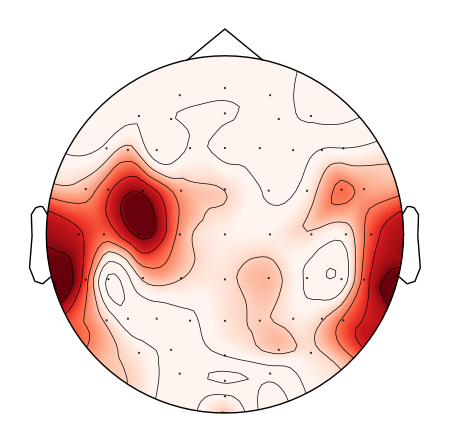

sub 2, 12 Hz trials, SNR at 12 Hz
average SNR (all channels): 1.091757
average SNR (occipital ROI): nan
12 Hz SNR in occipital ROI is significantly larger than 12 Hz SNR over all channels: t = nan, p = nan


/tmp/ipykernel_1708766/3453079481.py:11: RuntimeWarning: Mean of empty slice.
  print("average SNR (occipital ROI): %f" % snrs_target.mean())
/mnt/nfs/homes/oel-ayad/.local/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1708766/3453079481.py:13: RuntimeWarning: Mean of empty slice.
  tstat_roi_vs_scalp = ttest_rel(snrs_target.mean(axis=1), snrs_12hz.mean(axis=1))
/mnt/nfs/homes/oel-ayad/.local/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


In [272]:
# get average SNR at 12 Hz for ALL channels
snrs_12hz = snrs[i_trial_12hz, :, i_bin_12hz]
snrs_12hz_chaverage = snrs_12hz.mean(axis=0)

# plot SNR topography
fig, ax = plt.subplots(1)
mne.viz.plot_topomap(snrs_12hz_chaverage, epochs.info, vlim=(1, None), axes=ax)

print("sub 2, 12 Hz trials, SNR at 12 Hz")
print("average SNR (all channels): %f" % snrs_12hz_chaverage.mean())
print("average SNR (occipital ROI): %f" % snrs_target.mean())

tstat_roi_vs_scalp = ttest_rel(snrs_target.mean(axis=1), snrs_12hz.mean(axis=1))
print(
    "12 Hz SNR in occipital ROI is significantly larger than 12 Hz SNR over "
    "all channels: t = %.3f, p = %f" % tstat_roi_vs_scalp
)